In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

proj_root = os.path.dirname(os.path.abspath("."))
# print(proj_root)
sys.path.append(proj_root)

import time
import datetime
import torch
import random
import numpy as np
import os
from pathlib import Path
import argparse

import torch.optim as optim
import torch.nn.functional as F

import gym
import yaml

from minatar_dqn.my_dqn import AgentDQN
from minatar_dqn.replay_buffer import ReplayBuffer
from minatar_dqn.utils.my_logging import setup_logger
from minatar_dqn.models import Conv_QNET, Conv_QNET_one

from experiments.experiment_utils import (
    seed_everything,
    search_files_containing_string,
    split_path_at_substring,
    collect_training_output_files,
)

from minatar_dqn.my_dqn import Conv_QNET, build_environment
from minatar_dqn.redo import (
    apply_redo_parametrization,
    reset_optimizer_states,
    map_layers_to_optimizer_indices,
)
from experiments.experiment_utils import (
    collect_training_output_files,
    collect_pruning_output_files,
)

from experiments.training.training import read_config_files, get_config_paths

from flatten_dict import flatten
import pandas as pd
import seaborn as sns
import scipy

sns.set()

import plotly

plotly.io.kaleido.scope.mathjax = None

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Setup config
root_dir = os.path.dirname(os.path.abspath("."))

path_experiments_configs = os.path.join(
    root_dir, "experiments", "training", "training_configs"
)
path_experiments_outputs = os.path.join(root_dir, "experiments", "training", "outputs")

default_config_path, experiment_config_paths = get_config_paths(
    path_experiments_configs
)

experiment_configs = read_config_files(default_config_path, experiment_config_paths)

experiment_configs[0]

{'epochs_to_train': 20,
 'seeds': [0],
 'environments': ['asterix'],
 'agent_params': {'agent': 'AgentDQN',
  'args_': {'train_step_cnt': 200000,
   'validation_enabled': True,
   'validation_step_cnt': 125000,
   'validation_epsilon': 0.001,
   'replay_start_size': 5000,
   'batch_size': 32,
   'training_freq': 4,
   'target_model_update_freq': 100,
   'loss_fcn': 'mse_loss',
   'gamma': 0.99,
   'epsilon': {'start': 1.0, 'end': 0.01, 'decay': 250000}}},
 'estimator': {'model': 'Conv_QNET',
  'args_': {'conv_hidden_out_size': 32, 'lin_hidden_out_size': 128}},
 'optim': {'name': 'Adam', 'args_': {'lr': 6.25e-05, 'eps': 0.00015}},
 'replay_buffer': {'max_size': 100000, 'action_dim': 1, 'n_step': 0},
 'redo': {'attach': True,
  'enabled': False,
  'tau': 0.1,
  'beta': 1,
  'redo_freq': 1000,
  'selection_option': None},
 'reward_perception': None,
 'experiment_name': 'conv32_lin128'}

In [4]:
config = experiment_configs[0]
config["environment"] = "breakout"
config["seed"] = 0

output_path = os.path.join(
    root_dir,
    "experiments",
    "redo",
)

In [5]:
config

{'epochs_to_train': 20,
 'seeds': [0],
 'environments': ['asterix'],
 'agent_params': {'agent': 'AgentDQN',
  'args_': {'train_step_cnt': 200000,
   'validation_enabled': True,
   'validation_step_cnt': 125000,
   'validation_epsilon': 0.001,
   'replay_start_size': 5000,
   'batch_size': 32,
   'training_freq': 4,
   'target_model_update_freq': 100,
   'loss_fcn': 'mse_loss',
   'gamma': 0.99,
   'epsilon': {'start': 1.0, 'end': 0.01, 'decay': 250000}}},
 'estimator': {'model': 'Conv_QNET',
  'args_': {'conv_hidden_out_size': 32, 'lin_hidden_out_size': 128}},
 'optim': {'name': 'Adam', 'args_': {'lr': 6.25e-05, 'eps': 0.00015}},
 'replay_buffer': {'max_size': 100000, 'action_dim': 1, 'n_step': 0},
 'redo': {'attach': True,
  'enabled': False,
  'tau': 0.1,
  'beta': 1,
  'redo_freq': 1000,
  'selection_option': None},
 'reward_perception': None,
 'experiment_name': 'conv32_lin128',
 'environment': 'breakout',
 'seed': 0}

In [6]:
config["agent_params"]["args_"]["train_step_cnt"] = 200_000
config["agent_params"]["args_"]["validation_step_cnt"] = 125_000
config["redo"]["beta"] = 1
config["redo"]["tau"] = 0.025

In [7]:
env_name = config["environment"]

logger = setup_logger(
    env_name=env_name,
    identifier_string="redo_test_experiment",
)
logger.info(
    f'Starting up experiment: {config["experiment_name"]}, environment: {config["environment"]}, seed: {config["seed"]}'
)

### Setup environments ###
train_env = build_environment(
    game_name=config["environment"], random_seed=config["seed"]
)
validation_env = build_environment(
    game_name=config["environment"], random_seed=config["seed"]
)

experiment_agent = AgentDQN(
    train_env=train_env,
    validation_env=validation_env,
    experiment_output_folder=output_path,
    experiment_name="redo_test_experiment",
    resume_training_path=None,
    save_checkpoints=True,
    logger=logger,
    config=config,
)

2023-11-07 10:07:35,675 - root - INFO - redo_test_experiment - Starting up experiment: conv32_lin128, environment: breakout, seed: 0
2023-11-07 10:07:35,682 - root - INFO - redo_test_experiment - Loaded configuration settings.
2023-11-07 10:07:35,690 - root - INFO - redo_test_experiment - Initialized newtworks and optimizer.
2023-11-07 10:07:35,691 - root - INFO - redo_test_experiment - Applied redo parametrization to policy model.
2023-11-07 10:07:35,692 - root - INFO - redo_test_experiment - Applied redo parametrization to target model.


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning:

WARN: The environment MinAtar/Breakout-v0 is out of date. You should consider upgrading to version `v1`.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning:

WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning:

WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.



In [8]:
experiment_agent.train(train_epochs=10)

2023-11-07 10:07:35,754 - root - INFO - redo_test_experiment - Starting training session at: 0
2023-11-07 10:07:35,755 - root - INFO - redo_test_experiment - Starting training epoch at t = 0


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)



2023-11-07 10:13:28,772 - root - INFO - redo_test_experiment - TRAINING STATS | Frames seen: 200000 | Episode: 11876 | Max reward: 8.0 | Avg reward: 1.0384809700235769 | Avg frames (episode): 16.837824183226676 | Avg max Q: -66.02887663526056 | Epsilon: 0.2278 | Train epoch time: 0:05:52.975827
2023-11-07 10:13:28,773 - root - INFO - redo_test_experiment - Starting validation epoch at t = 200000
2023-11-07 10:14:30,163 - root - INFO - redo_test_experiment - VALIDATION STATS | Max reward: 10.0 | Avg reward: 3.3184227965540094 | Avg frames (episode): 41.433399602385684 | Avg max Q: -51.378242020461364 | Validation epoch time: 0:01:01.375409
2023-11-07 10:14:30,164 - root - INFO - redo_test_experiment - Saving checkpoint at t = 200000 ...
2023-11-07 10:14:30,169 - root - DEBUG - redo_test_experiment - Models saved at t = 200000
2023-11-07 10:14:30,174 - root - DEBUG - redo_test_experiment - Training status saved at t = 200000
2023-11-07 10:14:38,054 - root - INFO - redo_test_experiment - 

True

In [9]:
scores_summary = {}
tau = 0.025
for epoch_scores in experiment_agent.redo_scores["policy"]:
    for layer_id, scores in enumerate(epoch_scores):
        scores_summary[layer_id] = scores_summary.get(layer_id, []) + [torch.sum(scores < tau)]
        
pd.DataFrame(scores_summary)

,0,1,2
0,tensor(17),tensor(2),tensor(115)
1,tensor(17),tensor(6),tensor(116)
2,tensor(17),tensor(6),tensor(115)
3,tensor(15),tensor(7),tensor(117)
4,tensor(17),tensor(7),tensor(116)
5,tensor(17),tensor(8),tensor(116)
6,tensor(16),tensor(6),tensor(118)
7,tensor(16),tensor(6),tensor(116)
8,tensor(15),tensor(7),tensor(116)
9,tensor(15),tensor(11),tensor(116)


2023-11-07 11:48:29,417 - matplotlib.pyplot - DEBUG - redo_test_experiment - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-11-07 11:48:29,418 - matplotlib.pyplot - DEBUG - redo_test_experiment - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-11-07 11:48:29,421 - matplotlib.font_manager - DEBUG - redo_test_experiment - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2023-11-07 11:48:29,422 - matplotlib.font_manager - DEBUG - redo_test_experiment - findfont: score(FontEntry(fname='c:\\Users\\Chainsword\\anaconda3\\envs\\general\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 2.05
2023-11-07 11:48:29,422 - matplotlib.font_manager - DEBUG - redo_test_experiment - findfont: score(FontEntry(fname='c:\\Users\\Chainsword\\anaconda3\\envs\\general\\lib\\s

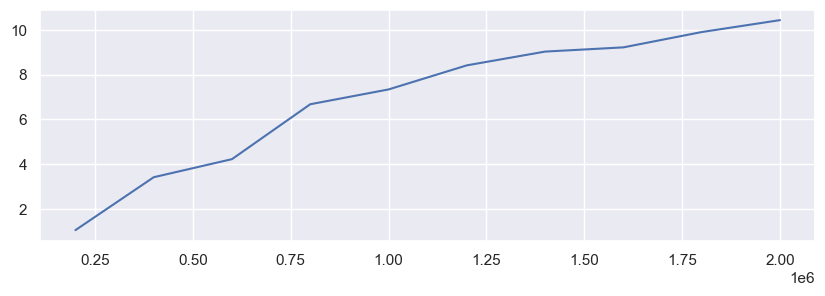

In [10]:
training_stats = {}
for stats in experiment_agent.training_stats:
    training_stats["frame_stamp"] = training_stats.get("frame_stamp", []) + [stats["frame_stamp"]]
    training_stats["episode_rewards_mean"] = training_stats.get("episode_rewards_mean", []) + [stats["episode_rewards"]["mean"]]
    
# Plot the training stats
fig = plt.figure(figsize=(10, 3))
plt.plot(training_stats["frame_stamp"], training_stats["episode_rewards_mean"])
plt.show()

In [11]:
# collect a set of states to check Q on before and after redo

eval_states = []

samples_nr = 100
skip_nr = 100
for i in range(samples_nr):
    for j in range(skip_nr):
        # get a random action from the environment
        action = experiment_agent.train_env.action_space.sample()
        s_prime, reward, is_terminated, truncated, info = experiment_agent.train_env.step(
            action
        )
        s_prime = torch.tensor(s_prime, device="cpu").float()

        if is_terminated:
            experiment_agent.train_env.reset()
            continue

    eval_states.append(s_prime)

In [12]:
import copy

eval_states_tensor = torch.stack(eval_states)

predictions_init = experiment_agent.policy_model(eval_states_tensor)
predictions_init

max_q_vals_init = []
for state in eval_states_tensor:
    max_q_val = experiment_agent.get_max_q_val_for_state(state.unsqueeze(0))
    max_q_vals_init.append(max_q_val)

# get the weights before redo
state_dict_init = copy.deepcopy(experiment_agent.policy_model.state_dict())

In [13]:
redo_scores = experiment_agent.policy_model.get_dormant_scores()
redo_scores

[tensor([0.0516, 0.0081, 0.0110, 0.0059, 0.0214, 0.0071, 0.0310, 0.0307, 0.0627,
         0.0327, 0.0344, 0.0200, 0.0163, 0.0446, 0.0457, 0.0053, 0.0448, 0.0665,
         0.0128, 0.0050, 0.0206, 0.0234, 0.0768, 0.0189, 0.0250, 0.0101, 0.0188,
         0.0260, 0.0664, 0.0428, 0.0642, 0.0497]),
 tensor([0.0318, 0.0229, 0.0944, 0.0268, 0.0370, 0.0269, 0.0363, 0.0373, 0.0233,
         0.0344, 0.0244, 0.0425, 0.0305, 0.0188, 0.0379, 0.0241, 0.0267, 0.0182,
         0.0381, 0.0251, 0.0120, 0.0366, 0.0247, 0.0183, 0.0309, 0.0400, 0.0284,
         0.0307, 0.0327, 0.0333, 0.0279, 0.0269]),
 tensor([0.0245, 0.0000, 0.0000, 0.0212, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0118, 0.0000, 0.0213, 0.0191, 0.0179, 0.0000, 0.0081, 0.0218, 0.0318,
         0.0000, 0.0000, 0.0123, 0.0000, 0.0433, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0130, 0.0166, 0.0000, 0.0326, 0.0167, 0.0000, 0.0076, 0.0000, 0.0093,
         0.0000, 0.0031, 0.0162, 0.0092, 0.0000, 0.0170, 0.0000, 0.0000, 0.0128,
       

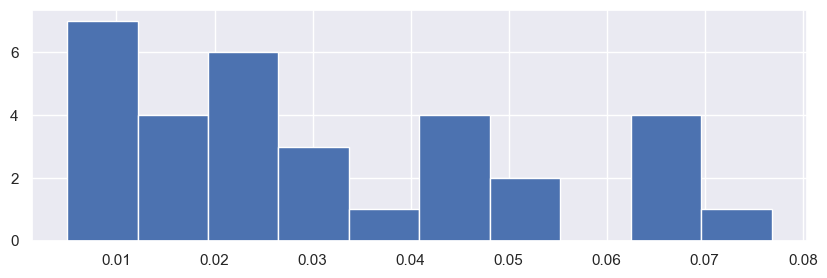

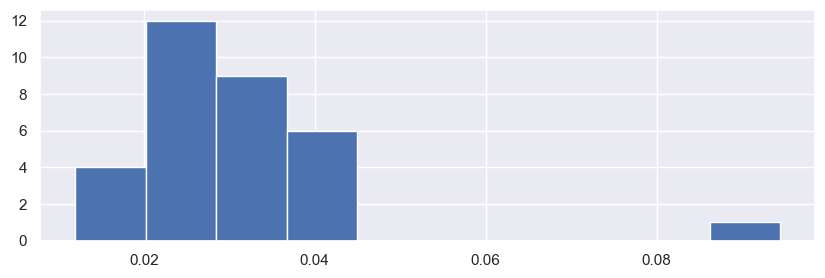

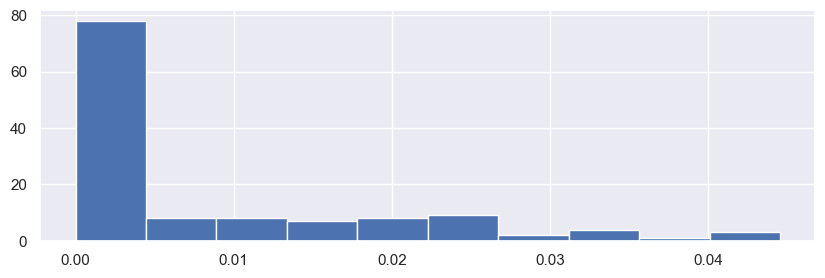

In [14]:
# Histogram of redo_scores
for scores in redo_scores:
    fig = plt.figure(figsize=(10, 3))
    plt.hist(scores)
    plt.show()


In [15]:
# apply redo
reset_details = experiment_agent.policy_model.apply_redo()
reset_details

[{'indexes': tensor([ 1,  2,  3,  4,  5, 11, 12, 15, 18, 19, 20, 21, 23, 24, 25, 26]),
  'inbound': 'features.conv1',
  'outbound': 'features.conv2'},
 {'indexes': tensor([ 1,  8, 10, 13, 15, 17, 20, 22, 23]),
  'inbound': 'features.conv2',
  'outbound': 'fc.lin1'},
 {'indexes': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
           14,  15,  16,  18,  19,  20,  21,  23,  24,  25,  26,  27,  28,  29,
           31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
           45,  46,  47,  48,  51,  52,  53,  54,  55,  56,  57,  59,  60,  61,
           62,  63,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
           78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
           92,  93,  94,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
          108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
          123, 124, 125, 126, 127]),
  'inbound': 'fc.lin1',
  'outbound': 'fc.lin

In [16]:
layer_to_optim_idx = map_layers_to_optimizer_indices(
    experiment_agent.policy_model, experiment_agent.optimizer
)
layer_to_optim_idx

reset_optimizer_states(reset_details, experiment_agent.optimizer, layer_to_optim_idx)

In [17]:
# get the difference between the values before and after
predictions_after = experiment_agent.policy_model(eval_states_tensor)
predictions_after

max_q_vals_after = []
for state in eval_states_tensor:
    max_q_val = experiment_agent.get_max_q_val_for_state(state.unsqueeze(0))
    max_q_vals_after.append(max_q_val)

# get the weights before redo
state_dict_after = experiment_agent.policy_model.state_dict()

In [18]:
predictions_after

tensor([[ -7.2510, -10.1932,  -5.3838,  -9.1227,  -7.9751,  -8.4717],
        [ -4.9013,  -6.9348,  -3.5470,  -7.2162,  -5.4098,  -5.5203],
        [ -2.3228,  -4.4616,  -0.5971,  -4.6242,  -2.7443,  -3.6718],
        [ -5.4787,  -7.5353,  -4.1476,  -8.0150,  -6.0141,  -5.8584],
        [-10.1153, -13.3113,  -8.0780, -11.5619, -11.0996, -11.1901],
        [ -8.2736, -10.6707,  -6.9086,  -9.4541,  -9.2097,  -8.9161],
        [ -5.4787,  -7.5353,  -4.1476,  -8.0150,  -6.0141,  -5.8584],
        [ -8.0048, -10.3884,  -6.6036,  -9.1424,  -8.8997,  -8.7312],
        [ -4.9611,  -7.0356,  -3.6786,  -6.9646,  -5.4990,  -5.7231],
        [ -4.9013,  -6.9348,  -3.5470,  -7.2162,  -5.4098,  -5.5203],
        [-12.9618, -17.2231, -10.3473, -15.0010, -14.0615, -14.3277],
        [ -9.3366, -12.1307,  -7.6308, -10.6863, -10.3018, -10.1769],
        [ -9.5907, -12.5365,  -7.8515, -11.1782, -10.5351, -10.4915],
        [ -6.3763,  -9.0680,  -4.6864,  -8.1376,  -7.0991,  -7.5595],
        [-13.0073, -

In [19]:
diff = np.array(max_q_vals_init) - np.array(max_q_vals_after)
sum(diff)

-2489.2977499961853

In [20]:
max_q_vals_init

[-62.20005416870117,
 -17.649883270263672,
 -28.075572967529297,
 -18.11956024169922,
 -39.21120071411133,
 -20.658533096313477,
 -18.11956024169922,
 -22.23553466796875,
 -23.688434600830078,
 -17.649883270263672,
 -31.99701690673828,
 -33.40391540527344,
 -17.78820037841797,
 -20.103391647338867,
 -32.902042388916016,
 -31.99701690673828,
 -25.210712432861328,
 -38.70685577392578,
 -30.26396369934082,
 -20.952857971191406,
 -21.283292770385742,
 -33.596580505371094,
 -20.992053985595703,
 -18.996315002441406,
 -38.00321960449219,
 -30.26396369934082,
 -21.234630584716797,
 -62.6223030090332,
 -47.53548812866211,
 -39.21120071411133,
 -17.78820037841797,
 -37.00579833984375,
 -48.16270446777344,
 -21.08529281616211,
 -20.006969451904297,
 -25.563749313354492,
 -21.08529281616211,
 -30.26396369934082,
 -48.16270446777344,
 -23.688434600830078,
 -37.00579833984375,
 -42.29832458496094,
 -17.78820037841797,
 -33.40391540527344,
 -20.103391647338867,
 -57.40166091918945,
 -33.002559661865

In [21]:
max_q_vals_after

[-5.383765697479248,
 -3.54701828956604,
 -0.5970851182937622,
 -4.147597312927246,
 -8.078014373779297,
 -6.908607482910156,
 -4.147597312927246,
 -6.603612899780273,
 -3.6785690784454346,
 -3.54701828956604,
 -10.347275733947754,
 -7.630749702453613,
 -7.851543426513672,
 -4.686438083648682,
 -10.390487670898438,
 -10.347275733947754,
 -6.95119571685791,
 -4.593059539794922,
 -6.95220947265625,
 -8.281596183776855,
 -2.096602201461792,
 -4.246218204498291,
 -1.5404995679855347,
 -5.497175216674805,
 -6.772350311279297,
 -6.95220947265625,
 -1.3345290422439575,
 -2.724208116531372,
 -7.577855110168457,
 -8.078014373779297,
 -7.851543426513672,
 -8.198747634887695,
 -4.480308532714844,
 -6.988248348236084,
 -1.8120824098587036,
 -6.427939414978027,
 -6.988248348236084,
 -6.95220947265625,
 -4.480308532714844,
 -3.6785690784454346,
 -8.198747634887695,
 -4.194922924041748,
 -7.851543426513672,
 -7.630749702453613,
 -4.686438083648682,
 -7.647066116333008,
 -1.215732216835022,
 -2.996421

In [22]:
for layer in state_dict_after:
    if not torch.equal(state_dict_init[layer], state_dict_after[layer]):
        print(f"Weights changed in layer: {layer}")

Weights changed in layer: features.conv1.weight
Weights changed in layer: features.conv1.bias
Weights changed in layer: features.relu1.running_avg
Weights changed in layer: features.relu1.running_avg_cnt
Weights changed in layer: features.conv2.weight
Weights changed in layer: features.conv2.bias
Weights changed in layer: features.relu2.running_avg
Weights changed in layer: features.relu2.running_avg_cnt
Weights changed in layer: fc.lin1.weight
Weights changed in layer: fc.lin1.bias
Weights changed in layer: fc.relu3.running_avg
Weights changed in layer: fc.relu3.running_avg_cnt
Weights changed in layer: fc.lin2.weight


### Lightweight test